In [18]:
import networkx as nx
from IPython.display import Image, HTML, display, clear_output
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Any
import itertools
import numpy as np
import seaborn as sns
from collections import OrderedDict
from datetime import datetime
import scipy
import os
from dataclasses import dataclass, field
from statsmodels.distributions.empirical_distribution import ECDF
from functools import lru_cache
import math

In [19]:
import so_ana_doc_worker.so_ana_reporting as so_ana_reporting
from sqlalchemy_models.db_deps import prod_db_deps_container, dict_to_es_key
import so_ana_management.management_utils as so_ana_mu
from so_ana_util import data_access

# Constants

In [20]:
ROOT_PATH = r'C:\Users\d91109\Documents\work\git\MBA\python\data\dictionaries\networkanalysis'
nr_topics = 10
NR_ITERATE = 10000
EXP_PATH_USER_GRAPH = os.path.join(ROOT_PATH, 'user_graph.xlsx')
EXP_PATH_DOC_GRAPH = os.path.join(ROOT_PATH, 'document_graph.xlsx')
EXP_PATH_DISTR =  os.path.join(ROOT_PATH, 'graph_distribution_@GRAPHNAME@.xlsx')

# Define relevant helper objects

In [21]:
@dataclass
class ProgressBar:
    heading: str
    progr_str: str = field(default='Progress: {ratio:.4f}%')
    duration_prfx_str: str = field(default='Duration: ')
    width_total_in_px: int = field(default=500)
    height_total_in_px: int = field(default=30)
    bg_color: str = field(default='DodgerBlue')
    txt_color: str = field(default='White')
        
    def take_time_snapshot(self):
        self.curr_time = datetime.now()
    
    def update_progress(self, progress):
        if progress == 0:
            self.take_time_snapshot()
        if isinstance(progress, int):
            progress = float(progress)
        if not isinstance(progress, float):
            progress = 0
        if progress < 0:
            progress = 0
        if progress >= 1:
            progress = 1
            
        clear_output(wait = True)

        width = int(progress * (self.width_total_in_px - 2))
        ratio_txt = self.progr_str.format(ratio=100*progress)
        time_delta_str = self.duration_prfx_str + str(datetime.now()-self.curr_time)
        html_txt = f'<h2>{self.heading}</h2>'
        html_txt += f'<div>{ratio_txt}</div>'
        html_txt += f'<div style="width:{self.width_total_in_px}px;height:{self.height_total_in_px}px;border:1px solid #000;">'
        html_txt += f'<div style="width:{width}px;height:{self.height_total_in_px-2}px;border:1px solid #000;background-color:{self.bg_color};color:{self.txt_color}">'
        html_txt += '</div></div>'
        html_txt += f'<div>{time_delta_str}</div>'
        display(HTML(html_txt))

# Get db connection data

In [22]:
deps = prod_db_deps_container()

In [23]:
all_jobs = so_ana_reporting.ReportingDataAccess.load_all_job_data(deps.conn)
flow_run_id = all_jobs.sort_values('started_at_timest', ascending=False).iloc[0, :]['flow_run_id']

display(HTML(f'<h1>Last flow-run-id is: "{flow_run_id}""</h1>'))
display(HTML('<hr width="85%" align="left">'))
print()

all_steps = so_ana_reporting.ReportingDataAccess.load_all_step_data_for_flow_run_id(  connection=deps.conn,
                                                                                      flow_run_id=flow_run_id)
display(HTML(f'<h1>Steps for flow-run-id="{flow_run_id}"</h1>'))
display(all_steps.sort_index())

display(HTML('<hr width="85%" align="left">'))
print()
display(HTML(f'<h1>Further jobs available"</h1>'))
all_jobs

,flow_name,flow_id,flow_run_id,flow_run_name,step_label,...,result,exit_code,exit_msg,prev_step_lbls,modus
step,,,,,,,,,,,
#1,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,dwnl_adm_new_reporting_2021_02_05_#1,...,"{'step': '#1', 'label': 'dwnl_adm_new_reportin...",0,None,[],test
#2,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,dwnl_adm_new_reporting_2021_02_05_#2,...,"{'step': '#2', 'label': 'dwnl_adm_new_reportin...",0,None,[dwnl_adm_new_reporting_2021_02_05_#1],test
#3,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,dwnl_adm_new_reporting_2021_02_05_#3,...,"{'step': '#3', 'label': 'dwnl_adm_new_reportin...",0,None,"[dwnl_adm_new_reporting_2021_02_05_#1, dwnl_ad...",test
#4,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,vect_adm_new_reporting_2021_02_05,...,"{'step': '#4', 'label': 'vect_adm_new_reportin...",0,None,"[dwnl_adm_new_reporting_2021_02_05_#1, dwnl_ad...",test
#5,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,vect_adm_new_reporting_2021_02_05,...,"{'step': '#5', 'label': 'vect_adm_new_reportin...",0,None,"[dwnl_adm_new_reporting_2021_02_05_#1, dwnl_ad...",test
#6,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,ml_opts_adm_new_reporting_2021_02_05,...,"{'step': '#6', 'step_label': 'ml_opts_adm_new_...",0,None,"[dwnl_adm_new_reporting_2021_02_05_#1, dwnl_ad...",test
#7,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,rep_adm_new_reporting_2021_02_05,...,"[{'step': '#7', 'step_label': 'rep_adm_new_rep...",0,None,"[dwnl_adm_new_reporting_2021_02_05_#1, dwnl_ad...",test
#8,so-analysis,so-analysis,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,reporting_eef6eb90-904e-468e-bbf8-17f5e897d359,...,"[{'step': '#1', 'label': 'dwnl_adm_new_reporti...",0,None,"[dwnl_adm_new_reporting_2021_02_05_#1, dwnl_ad...",test


,description,flow_name,flow_id,flow_run_id,flow_run_name,...,flow_opts,result,step_2_info,use_step_label,use_step_step
0,Flows for anemic domain models (for testing an...,so-analysis,fee42c05-c884-4c9e-9ef1-cae85d549cdd,803fb75f-eea8-4529-a1e9-55299035f152,test run: anemic domain model,...,{'description': 'Flows for anemic domain model...,"[{'step': '#1', 'label': 'dwnl_adm_new_reporti...","{'#1': {'step': '#1', 'label': 'dwnl_adm_new_r...",None,None


# Define relevant graph object 

In [24]:
@dataclass(frozen=True)
class DocInfo:
    post_id: int
        
@dataclass(frozen=True)
class UserInfo:
    user_url: str
               
        
def multi_graph_2_weighted_graph(gr):
    if gr.is_directed():
        new_gr = nx.DiGraph(name='Reduced' + gr.graph['name'])
    else:
        new_gr = nx.Graph(name='Reduced' + gr.graph['name'])
    
    for node in gr.nodes:
        new_gr.add_node(node)
    
    for edge in gr.edges:
        if new_gr.has_edge(edge[0], edge[1]):
            new_gr[edge[0]][edge[1]]['weight'] += 1
        else:
            new_gr.add_edge(edge[0], edge[1], weight=1)
            
    return new_gr

def reverse(gr):
    res = gr.reverse(copy=True)
    res.graph['name'] = 'Reversed' + res.graph['name']
    return res

    
class DocUserGraph:
    
    def __init__(self):
        self.G = nx.MultiDiGraph()
        
    def add_document(self,post_id, user_url, topic_tuple, answ_user_url_lst):
        doc_node = DocInfo(post_id=post_id)
        user_node = UserInfo(user_url=user_url)
        self.G.add_node(doc_node, topic_weights=np.array(topic_tuple))
        self.G.add_node(user_node)
        self.G.add_edge(doc_node, user_node)
        for item in answ_user_url_lst:
            answ_user_node = UserInfo(user_url=item)
            self.G.add_node(answ_user_node)
            self.G.add_edge(answ_user_node, doc_node)
    
    def _get_user_weight(self, user_info):
        weight = None
        for ng in  itertools.chain(self.G.successors(user_info), self.G.predecessors(user_info)):
            if weight is None:
                weight = np.copy(self.G.nodes[ng]['topic_weights'])
            else:
                weight += self.G.nodes[ng]['topic_weights']         
                
        return weight / np.sum(weight)
    
    @property        
    def user_response_graph(self):
        new_gr = nx.MultiDiGraph(name='UserResponseGraph')
        for node in self.G:
            if isinstance(node, UserInfo):
                weight = self._get_user_weight(node)
                new_gr.add_node(node, topic_weights=weight)
                for ng1 in self.G.successors(node):
                    for ng2 in self.G.successors(ng1):
                        if not ng2 == UserInfo(None):
                            weight2 = self._get_user_weight(ng2)
                            new_gr.add_node(ng2, topic_weights=weight2)
                            new_gr.add_edge(node, ng2)             
        return new_gr
    
    @property 
    def document_contr_graph(self):
        new_gr = nx.MultiGraph(name='DocumentUserSharedGraph')
        node_set = set()
        for node in self.G:
            if isinstance(node, DocInfo):
                weight = self.G.nodes[node]['topic_weights']
                new_gr.add_node(node, topic_weights=weight)
                node_set.add(node)
                for ng1 in itertools.chain(self.G.successors(node), self.G.predecessors(node)):
                    for ng2 in itertools.chain(self.G.successors(ng1), self.G.predecessors(ng1)):
                        if not ng2 in node_set:
                            weight2 = self.G.nodes[ng2]['topic_weights']
                            new_gr.add_node(ng2, weight_vector=weight2)
                            new_gr.add_edge(node, ng2)
        return new_gr
        

# Construct basic graph

In [25]:
# get document iterator for relevant step
doc_iterator = data_access.get_doc_iterator(connection=deps.conn,
                                            d2es_obj=deps.d2es,
                                            step_label=all_steps.loc['#3']['step_label'],
                                            format = 'all_#3',
                                            ml_tags=None
                    )

nr_docs = len(doc_iterator)

# create relevant graph
graph = DocUserGraph()

query = 'select user_url from so_ana_doc_worker.page_meta_info ' \
        'where step=%(step)s and step_label=%(step_label)s and post_id=%(post_id)s'

query2 = 'select topic_id, topic_weight from so_ana_analysis.topic_distribution '\
         'where step=%(step)s and step_label=%(step_label)s and post_id=%(post_id)s order by topic_id asc'

progr_bar = ProgressBar('Constructing document-user graph...')

for i, qu in enumerate(doc_iterator):
    if i % 10 == 0:
        progr_bar.update_progress(i/nr_docs)
    res = deps.conn.execute(query,   {'step': '#1',
                                      'step_label': all_steps.loc['#1']['step_label'],
                                      'post_id': qu.post_id
                             }).fetchone()[0]
    weight_res = {item[0]: item[1] for item in  deps.conn.execute(query2,   { 'step': '#7',
                                                                              'step_label': all_steps.loc['#7']['step_label'],
                                                                              'post_id': qu.post_id
                                                                     }
                                                          )
                 }
    graph.add_document(post_id=qu.post_id, user_url=res,  topic_tuple=tuple([weight_res.get(i, 0) for i in range(nr_topics)]), answ_user_url_lst=[answ.user_url for answ in qu.answers])

progr_bar.update_progress(1.0)

# Load relevant data into pandas data frames "user_response_data" and "doc_response_data"

In [26]:
def user_iterator(user_response_graph):
    for node in user_response_graph.nodes():
        wv = user_response_graph.nodes[node]['topic_weights']
        in_deg = user_response_graph.in_degree(node)
        out_deg = user_response_graph.out_degree(node)
        yield [node.user_url, in_deg, out_deg, out_deg-in_deg] + wv.tolist()

        
def doc_iterator(doc_graph):
        for node in doc_graph.nodes():
            wv = doc_graph.nodes[node]['topic_weights']
            yield [node.post_id, doc_graph.degree(node)] + wv.tolist()

    
    
user_response_graph = graph.user_response_graph        
user_response_data = pd.DataFrame.from_records(user_iterator(user_response_graph), columns=['user', 'in degree', 'out degree', 'degree difference'] + [f'weight {i}' for i in range(nr_topics)])

display(HTML('<h1>User response graph</h1>'))
display(user_response_data.head())

doc_graph = graph.document_contr_graph
doc_response_data = pd.DataFrame.from_records(doc_iterator(doc_graph), columns=['document', 'degree'] + [f'weight {i}' for i in range(nr_topics)])

display(HTML('<h1>Doc contribution graph</h1>'))
display(doc_response_data.head())




,user,in degree,out degree,degree difference,weight 0,...,weight 5,weight 6,weight 7,weight 8,weight 9
0,/users/3090433/yassine-bsf,2,0,-2,0.0,...,0.0,0.0,0.0,0.0,0.0
1,/users/54734/voiceofunreason,0,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0
2,/users/3132197/yevgenyl,2,0,-2,0.0,...,0.0,0.0,0.0,0.0,0.0
3,/users/2579875/born-free,2,0,-2,0.0,...,0.0,0.0,0.0,0.0,0.0
4,/users/188138/brad-irby,0,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0


,document,degree,weight 0,weight 1,weight 2,...,weight 5,weight 6,weight 7,weight 8,weight 9
0,51193522,2,0.0,0.991464,0.000000,...,0.0,0.0,0.0,0.0,0.0
1,70314017,2,0.0,0.997070,0.000000,...,0.0,0.0,0.0,0.0,0.0
2,42259941,2,0.0,0.996784,0.000000,...,0.0,0.0,0.0,0.0,0.0
3,29618269,0,0.0,0.994720,0.000000,...,0.0,0.0,0.0,0.0,0.0
4,22408046,0,0.0,0.944577,0.026365,...,0.0,0.0,0.0,0.0,0.0


# Augment node level graph data

In [27]:
class AugmentedMapper:
    
    def __init__(self, DC):
        self.DC = DC
        self.mapping_dict = {}
       
    def __call__(self, x):
        return self.mapping_dict[self.DC(x)]     

class HashedReturn:
    
    def __init__(self, rel_func):
        self.rel_func = rel_func
        self._res = None
        self.key_hsh = ''
        self.val_hsh = ''
        self.gr_name = ''
        
    def __call__(self, gr, **kwargs):
        recalc = (self._res is None) or (self.key_hsh != hash(tuple(kwargs.keys()))) or (self.val_hsh != hash(tuple(kwargs.values()))) or (self.gr_name != gr.graph['name'])
        self.key_hsh =  hash(tuple(kwargs.keys()))
        self.val_hsh = hash(tuple(kwargs.values()))
        self.gr_name = gr.graph['name']
        if recalc:
            self._res = self.rel_func(gr, **kwargs)
        return self._res
    
def get_projection(f, pos):
    def _inner(*args, **kwargs):
        return f(*args, **kwargs)[pos]
    return _inner         
        

def augment_centralities(df, graph):
    red_graph =  multi_graph_2_weighted_graph(graph)
    gr_name = graph.graph['name']
    res_dict = {}
    if gr_name == 'UserResponseGraph':
        aug_mapper = AugmentedMapper(UserInfo)
        rel_label = 'user'
        hsh_hits_func = HashedReturn(nx.algorithms.link_analysis.hits_alg.hits)
        
        lbl_lst = [ ('centrality_in_degree',  nx.algorithms.centrality.in_degree_centrality, {}),
                    ('centrality_out_degree',  nx.algorithms.centrality.out_degree_centrality, {}),
                    ('centrality_eigenvector',  nx.algorithms.centrality.eigenvector_centrality, dict(weight='weight', tol=1.0e-6)),
                    ('centrality_page_rank',  nx.algorithms.link_analysis.pagerank_alg.pagerank, dict(alpha=0.85, weight='weight', tol=1.0e-6)),
                    ('centrality_hits_hubs',  get_projection(hsh_hits_func, 0), {}),
                    ('centrality_hits_authorities',  get_projection(hsh_hits_func, 1), {}),
                    ('centrality_harmonic',  nx.algorithms.centrality.harmonic_centrality, {})
                  ]
    elif gr_name == 'DocumentUserSharedGraph':
        aug_mapper = AugmentedMapper(DocInfo)
        rel_label = 'document'
        lbl_lst = [ ('centrality_degree',  nx.algorithms.centrality.degree_centrality, {}),
                    ('centrality_eigenvector',  nx.algorithms.centrality.eigenvector_centrality, dict(weight='weight', tol=1.0e-6)),
                    ('centrality_page_rank',  nx.algorithms.link_analysis.pagerank_alg.pagerank, dict(alpha=0.85, weight='weight', tol=1.0e-6)),
                    ('centrality_harmonic',  nx.algorithms.centrality.harmonic_centrality, {})
                  ]
    elif gr_name == 'ReversedUserResponseGraph':
        lbl_lst = [ ('centrality_reversed_page_rank',  nx.algorithms.link_analysis.pagerank_alg.pagerank, dict(alpha=0.85, weight='weight', tol=1.0e-6))]
        rel_label = 'user'
        aug_mapper = AugmentedMapper(UserInfo)
        
    for label, alg, kwargs in lbl_lst:
        print(f'calculating "{label}" for graph "{gr_name}"...')
        res_dict[label] = alg(red_graph, **kwargs)

    for label, rel_dict in res_dict.items():
        print(f'starting {label} for graph {gr_name}')
        aug_mapper.mapping_dict = rel_dict
        df[label] = df[rel_label].map(aug_mapper)
    return df

for rel_data, rel_gr in [(doc_response_data, doc_graph), (user_response_data, user_response_graph), (user_response_data, reverse(user_response_graph))]:
    gr_name = rel_gr.graph['name']
    display(HTML(f'<h2>{gr_name}</h2>'))
    rel_data = augment_centralities(rel_data, rel_gr)  
    display(rel_data.head()) 

calculating "centrality_degree" for graph "DocumentUserSharedGraph"...
calculating "centrality_eigenvector" for graph "DocumentUserSharedGraph"...


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

 # Plot histograms

Kennzahlen


,degree
count,66.000000
mean,1.151515
std,1.638408
min,0.000000
0.1%,0.000000
1%,0.000000
5%,0.000000
10%,0.000000
20%,0.000000
30%,0.000000


skewness: 1.319896321903164
kurtosis: 0.7395057887052885


Kennzahlen


,in degree
count,180.000000
mean,0.772222
std,1.494237
min,0.000000
0.1%,0.000000
1%,0.000000
5%,0.000000
10%,0.000000
20%,0.000000
30%,0.000000


skewness: 3.0430667547308503
kurtosis: 11.905896444159884


Kennzahlen


,out degree
count,180.000000
mean,0.772222
std,0.746168
min,0.000000
0.1%,0.000000
1%,0.000000
5%,0.000000
10%,0.000000
20%,0.000000
30%,0.000000


skewness: 2.255065339715887
kurtosis: 10.516857903480814


<Figure size 432x288 with 0 Axes>

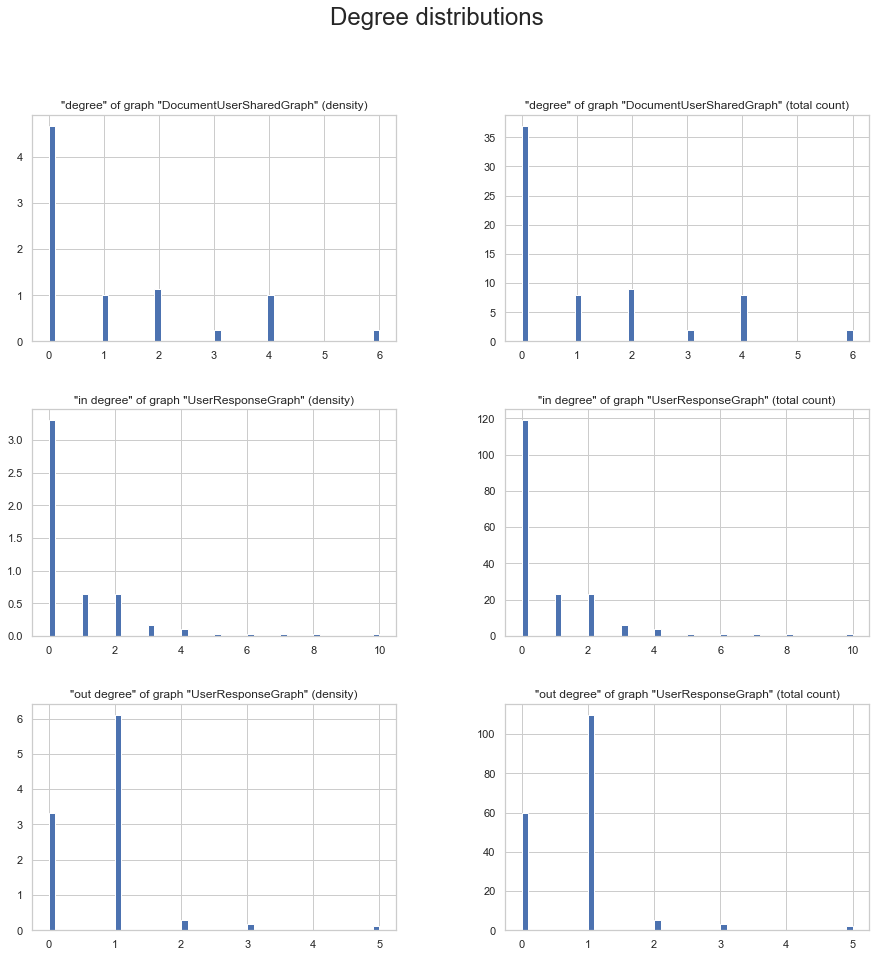

In [28]:
sns.set_theme(style="whitegrid")
sns.despine()

fig1, f1_axes = plt.subplots(ncols=2, nrows=3, constrained_layout=True, figsize=(15, 15))
plt.suptitle('Degree distributions', fontsize=24)

for i, (rel_data, lbl, gr_name) in enumerate(
                                                [(doc_response_data, 'degree', doc_graph.graph['name']), 
                                                 (user_response_data, 'in degree', user_response_graph.graph['name']), 
                                                 (user_response_data, 'out degree', user_response_graph.graph['name'])
                                                ]
                                            ):
    rel_txt = f'"{lbl}" of graph "{gr_name}"'
    display(HTML(f'<h2>Plotting histogram for distribution of ' + rel_txt + '</h2>'))
    for j, bool_density in enumerate([True, False]):
        rel_data[[lbl]].hist(bins=50, density=bool_density, ax = f1_axes[i, j])
        f1_axes[i, j].set_title(rel_txt + (' (density)' if bool_density else ' (total count)'))

    print('Kennzahlen')
    display(rel_data[[lbl]].describe(percentiles=[.001, 0.01, 0.05, 0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.95, .99, 0.999]))
    descr = scipy.stats.describe(rel_data[lbl])
    for attri in ['skewness', 'kurtosis']:
        print(f'{attri}: {getattr(descr, attri)}')

# Export node level graph data

In [12]:
user_response_data.to_excel(EXP_PATH_USER_GRAPH)
doc_response_data.to_excel(EXP_PATH_DOC_GRAPH)

# Calculate key metrics for relevant graphs

In [30]:
display(HTML(f'<h1>Key metrics of graphs</h1>'))
for gr in (graph.G, user_response_graph, doc_graph, multi_graph_2_weighted_graph(user_response_graph), multi_graph_2_weighted_graph(doc_graph)):
    gr_name = gr.graph.get('name', 'FullDocumentUserGraph')
    display(HTML(f'<h2>{gr_name}</h2>'))
    nr_nodes = gr.number_of_nodes()
    nr_edges = gr.number_of_edges()
    print('number of nodes: ', nr_nodes)
    print('number of edges: ', nr_edges)
    print('average degree: ', nr_edges/nr_nodes)
    if gr_name in ('UserResponseGraph', 'ReducedUserResponseGraph', 'FullDocumentUserGraph'):
        print('Strongly connected components: ', nx.number_strongly_connected_components(gr))
        print('Weakly connected components: ', nx.number_weakly_connected_components(gr))
    elif gr_name in ('DocumentUserSharedGraph', 'ReducedDocumentUserSharedGraph'):
        print('Connected components: ', nx.number_connected_components(gr))
        

number of nodes:  246
number of edges:  205
average degree:  0.8333333333333334
Strongly connected components:  244
Weakly connected components:  44


number of nodes:  180
number of edges:  139
average degree:  0.7722222222222223
Strongly connected components:  180
Weakly connected components:  44


number of nodes:  66
number of edges:  38
average degree:  0.5757575757575758
Connected components:  44


number of nodes:  180
number of edges:  139
average degree:  0.7722222222222223
Strongly connected components:  180
Weakly connected components:  44


number of nodes:  66
number of edges:  37
average degree:  0.5606060606060606
Connected components:  44


# Calculate average cosine similarity and randomized empirical distribution of cosine similarity

In [31]:
class CosSimCalculator:
    
    def __init__(self, graph):
        self.graph = graph
        nr_nodes = graph.number_of_nodes()
        for node in graph.nodes():
            nr_weights = graph.nodes[node]['topic_weights'].shape[0]
            break
        self.weight_array = np.zeros(shape=(nr_nodes, nr_weights), dtype=float)
        self.node2posdict = {}
        for i, node in enumerate(graph.nodes()):
            self.node2posdict[node] = i
            for j in range(nr_weights):
                self.weight_array[i, j] = graph.nodes[node]['topic_weights'][j]
        
        self.edge_list = []
        for edge in graph.edges():
            self.edge_list.append((self.node2posdict[edge[0]], self.node2posdict[edge[1]]))
        self.nodepair_2_value_dict = {}
        
    @property
    def nr_edges(self):
        return len(self.edge_list)
    
    @property
    def nr_nodes(self):
        return self.weight_array.shape[0]
    
    @property
    def nr_weights(self):
        return self.weight_array.shape[1]
    
    def get_cos_sim(self, i, j):
        a = self.weight_array[i]
        b = self.weight_array[j]
        return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))
    
    def __call__(self, permut_array = None):
        if permut_array is None:
            permut_array = np.arange(self.nr_nodes)
        sum_of_cos = 0.0
        for e1, e2 in self.edge_list:
            i = permut_array[e1]
            j = permut_array[e2]
            if i<=j:
                key = (i, j)
            else:
                key = (j, i)
            new_cos_sim = self.nodepair_2_value_dict.get(key, 0)
            if new_cos_sim == 0:
                new_cos_sim = self.get_cos_sim(i, j)
                self.nodepair_2_value_dict[key] = new_cos_sim
            sum_of_cos += new_cos_sim
        
        return sum_of_cos / self.nr_edges
        
@dataclass
class SimilarityCalculationResult:
    graph: Any
    NR_ITERATE: int = 100
    res_avg_cos_sim: float = 0.0
    res_emp_cos_sim_dist: pd.DataFrame = None
        
    def calculate_emp_distr(self, progr_bar):
        cos_sim_calc = CosSimCalculator(self.graph)
        self.res_avg_cos_sim = cos_sim_calc()
        nr_nodes = cos_sim_calc.nr_nodes
        
        res_lst = []
        for i in range(self.NR_ITERATE):
            rnd_perm = np.random.permutation(nr_nodes)
            progr_bar.update_progress(i/self.NR_ITERATE)
            res_lst.append(cos_sim_calc(rnd_perm))
        progr_bar.update_progress(1.0)
        self.res_emp_cos_sim_dist = pd.DataFrame(res_lst, columns=['random cosine similarity'])
         
#generate calculation results
cos_sim_res_lst = []
for gr in [user_response_graph, doc_graph]: 
    new_res = SimilarityCalculationResult(graph = gr, NR_ITERATE = NR_ITERATE)
    gr_name = gr.graph['name']
    progr_bar = ProgressBar(f'Calculating results for graph "{gr_name}"...')
    new_res.calculate_emp_distr(progr_bar)
    cos_sim_res_lst.append(new_res)

#output most average cosine similarity and its quantile within the emirical distribution
display(HTML('<h1>Results</h1>'))
for res in cos_sim_res_lst:
    gr_name = res.graph.graph['name']
    display(HTML(f'<h2>Graph "{gr_name}"</h2>'))
    print('Average cosine similarity of connected documents: ', res.res_avg_cos_sim)
    emp_dist = ECDF(res.res_emp_cos_sim_dist['random cosine similarity'])
    print('Average cosine similarity equates to the following quantile of empirical distribution: ', emp_dist(res.res_avg_cos_sim))



Average cosine similarity of connected documents:  0.9758060433777055
Average cosine similarity equates to the following quantile of empirical distribution:  1.0


Average cosine similarity of connected documents:  0.7340664575686319
Average cosine similarity equates to the following quantile of empirical distribution:  0.5720000000000001


# Eport Graph data

In [16]:
for res in cos_sim_res_lst:
    res.res_emp_cos_sim_dist.to_excel(EXP_PATH_DISTR.replace('@GRAPHNAME@', res.graph.graph['name']))

Average cosine similarity:  0.9758060433777055
Corresponding quantile in empirical distribution:  1.0
     -> Assortativity result is highly significant
VA-Index:  0.9842248009362576


,random cosine similarity
count,10000.000000
mean,0.785283
std,0.034248
min,0.602024
0.1%,0.657195
1%,0.693036
5%,0.723040
10%,0.738102
20%,0.757222
30%,0.770317


skewness: -0.5942823437813627
kurtosis: 0.3665250639576332


Average cosine similarity:  0.7340664575686319
Corresponding quantile in empirical distribution:  0.5720000000000001
     -> Assortativity result is not significant
VA-Index:  0.18973303442624906


,random cosine similarity
count,10000.000000
mean,0.714276
std,0.102413
min,0.365122
0.1%,0.420892
1%,0.471516
5%,0.544923
10%,0.579054
20%,0.626420
30%,0.658387


skewness: -0.0733006732775601
kurtosis: -0.26038284596134


<Figure size 432x288 with 0 Axes>

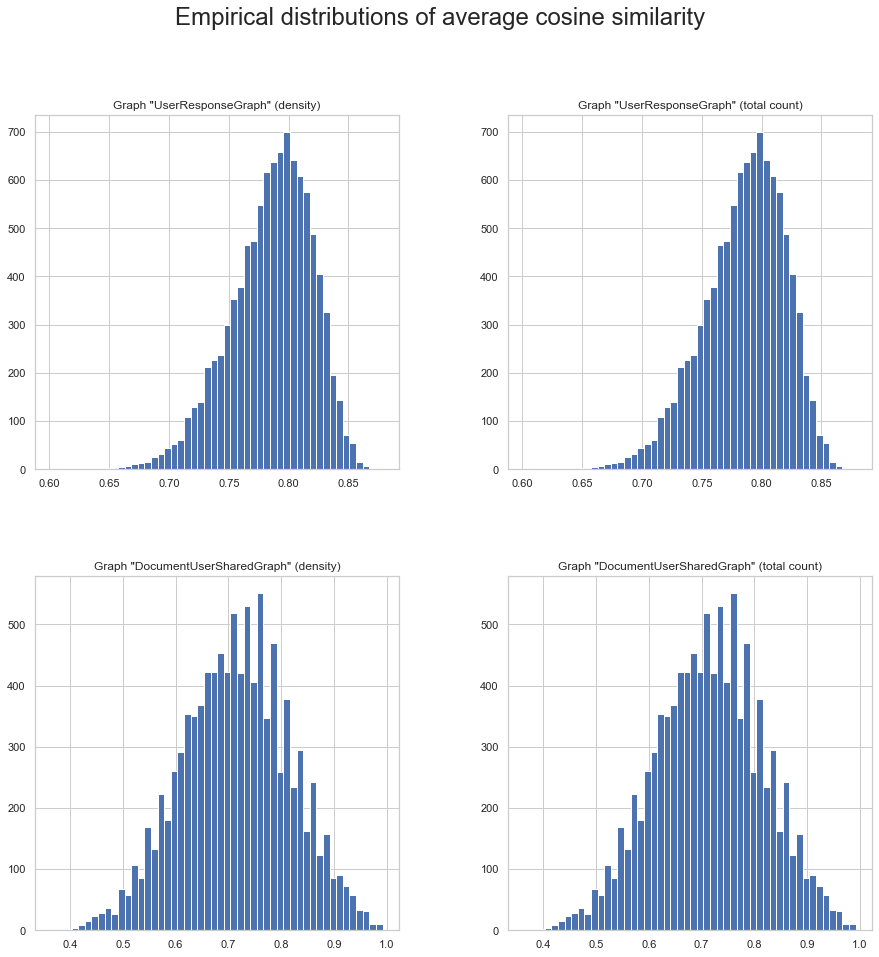

In [32]:
display(HTML('<h1>Key metrics of empirical cosine similarity distribution</h1>'))
sns.set_theme(style="whitegrid")
sns.despine()

fig2, f2_axes = plt.subplots(ncols=2, nrows=len(cos_sim_res_lst), constrained_layout=True, figsize=(15, 15), squeeze=False)
plt.suptitle('Empirical distributions of average cosine similarity', fontsize=24)

for i, res in enumerate(cos_sim_res_lst):
    gr_name = res.graph.graph['name']
    display(HTML(f'<h2>Graph "{gr_name}"</h2>'))
    for j, density_bool in enumerate([True, False]):
        res.res_emp_cos_sim_dist.hist(bins=50, ax = f2_axes[i, j])
        f2_axes[i, j].set_title(f'Graph "{gr_name}" ' + ('(density)' if density_bool else '(total count)'))

    print(f'Average cosine similarity: ',  res.res_avg_cos_sim)
    emp_dist = ECDF(res.res_emp_cos_sim_dist['random cosine similarity'])
    e_qu = emp_dist(res.res_avg_cos_sim)
    print('Corresponding quantile in empirical distribution: ', e_qu)
    if e_qu > 0.975 or e_qu < 0.025:
        txt = 'highly significant'
    elif e_qu > 0.95 or e_qu < 0.05:
        txt = 'significant'
    else:
        txt = 'not significant'
    print('     -> Assortativity result is ' + txt)
    descr_pd = res.res_emp_cos_sim_dist.describe(percentiles=[.001, 0.01, 0.05, 0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.95, .99, 0.999])
    d_for_VA =  (res.res_avg_cos_sim - descr_pd.loc['mean', 'random cosine similarity'])/descr_pd.loc['std', 'random cosine similarity']
    alpha_for_VA = d_for_VA/math.sqrt(d_for_VA*d_for_VA + 1.0)
    print('VA-Index: ', alpha_for_VA)
    display(descr_pd)
    descr = scipy.stats.describe(res.res_emp_cos_sim_dist['random cosine similarity'])
    for attri in ['skewness', 'kurtosis']:
        print(f'{attri}: {getattr(descr, attri)}')